In [1]:
import argparse
import codecs
import os
import re
from importlib.resources import files
from pathlib import Path
import numpy as np
import soundfile as sf
import tomli
from cached_path import cached_path

from model import DiT, CFM
import torch
from f5_tts.model.utils import (
    get_tokenizer,
    convert_char_to_pinyin,
)

from infer.utils_infer import (
    infer_process,
    load_vocoder,
    preprocess_ref_audio_text,
    remove_silence_for_generated_wav,
)

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")

cfg_strength = 3.0
scale_phi = 0.75

target_sample_rate = 24000
mel_spec_type  = "vocos"
vocoder_name   = "vocos"
n_mel_channels = 100
win_length     = 1024
hop_length     = int(win_length//4)
n_fft          = 1024
target_rms     = 0.1
ode_method     = "euler"
nfe_step       = 32  # 16, 32
speed          = 1.0
fix_duration   = None
vocab_file     = "./infer/examples/vocab.txt"
tokenizer      = "custom"
ode_method     = "euler"
cross_fade_duration = 0.15
sway_sampling_coef = -1.0

In [3]:
# load model
model_cfg = dict(
    dim=1024, 
    depth=22, 
    heads=16, 
    ff_mult=2, 
    text_dim=512, 
    conv_layers=4
)

vocab_char_map, vocab_size = get_tokenizer(vocab_file, tokenizer)
vocoder     = load_vocoder(vocoder_name=vocoder_name, is_local=True, local_path="./vocoder")
transformer = DiT(**model_cfg, text_num_embeds=vocab_size, mel_dim=n_mel_channels)

Load vocos from local path ./vocoder


In [4]:
mel_spec_kwargs=dict(
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    n_mel_channels=n_mel_channels,
    target_sample_rate=target_sample_rate,
    mel_spec_type=mel_spec_type,
)

odeint_kwargs=dict(
    method=ode_method,
)

model = CFM(
    transformer=transformer,
    mel_spec_kwargs=mel_spec_kwargs,
    odeint_kwargs=odeint_kwargs,
    vocab_char_map=vocab_char_map,
).to(device)

In [17]:
dtype = torch.float32
ckpt_path = './model_1200000_base.pt'
checkpoint = torch.load(ckpt_path, map_location=device, weights_only=True)

# 키 이름에서 "emewe_model." prefix 제거
new_state_dict = {
    k.replace("ema_model.", ""): v
    for k, v in checkpoint['ema_model_state_dict'].items()
    if k.startswith("ema_model.")
}

In [20]:
model.load_state_dict(new_state_dict, strict=False)
del checkpoint
torch.cuda.empty_cache()

In [21]:
text = ["I thought I saw you in my dream.", "Hey how are you?"]
duration = 3
audio, sr = torch.ones((2, 24000)), 24000
final_text_list = convert_char_to_pinyin(text)
print(final_text_list)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.800 seconds.
Prefix dict has been built successfully.


[['I', ' ', 't', 'h', 'o', 'u', 'g', 'h', 't', ' ', 'I', ' ', 's', 'a', 'w', ' ', 'y', 'o', 'u', ' ', 'i', 'n', ' ', 'm', 'y', ' ', 'd', 'r', 'e', 'a', 'm', '.'], ['H', 'e', 'y', ' ', 'h', 'o', 'w', ' ', 'a', 'r', 'e', ' ', 'y', 'o', 'u', '?']]


In [22]:
generated, sec = model.sample(
    cond=audio.to(device),
    text=final_text_list,
    duration=duration,
    steps=nfe_step,
    cfg_strength=cfg_strength,
    sway_sampling_coef=sway_sampling_coef,
    
    duplicate_test=False,
    t_inter=None,
    no_ref_audio=True,
    batch_size=1
)

before text  torch.Size([2, 32])
before text  torch.Size([2, 32])


In [23]:
generated = generated.to(torch.float32)
print(generated.shape)
generated_mel_spectrogram = generated.permute(0, 2, 1)
generated_wave_form = vocoder.decode(generated_mel_spectrogram)
print(generated_wave_form.shape)

torch.Size([2, 95, 100])
torch.Size([2, 24064])



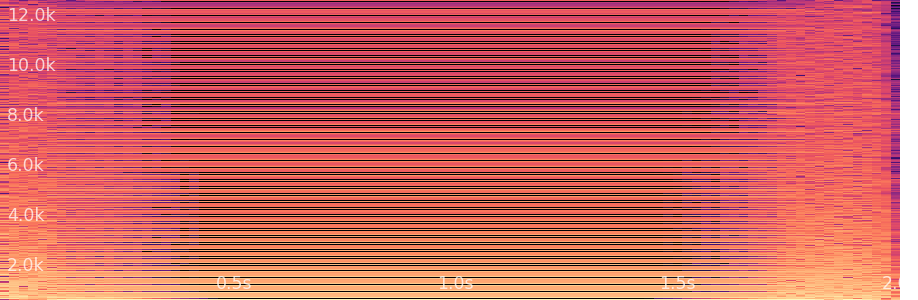
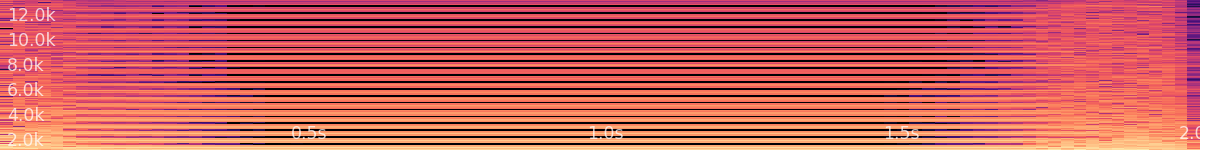

In [24]:
from audiotools import AudioSignal

AudioSignal(generated_wave_form.cpu().numpy(), sample_rate=24000).widget()